## Baseline Model for Northern Hemisphere

Before building a trainable model it would be good to have a performance baseline model for comparison with the more complicated models.

Here the dataset is splitted to two, train and test datasets. First we train the data with train dataset and then test with test dataset.

Calculated the monthly mean of the sea ice extent for the train period and used the monthly mean for the prediction. Here we used RMSE(Root Mean Squared Error) an an evaluation metric.

In [1]:
#import of the neccessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ftplib import FTP
import os
import warnings
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error

#from statsmodels.tsa.stattools import adfuller,kpss

warnings.filterwarnings('ignore')

### Importing the dataset

and preproccess it like we do in the EDA

In [240]:
df_n = pd.read_csv('../data/N_seaice_extent_daily_v3.0.csv')

#drop first row because it's the description
df_n = df_n.iloc[1:,:]

#drop Source Data column
df_n.drop(' Source Data', axis=1, inplace=True)
df_n.head()

#renaming the columns
df_n.rename(columns={'Year':'year', ' Month':'month', ' Day':'day', '     Extent':'extent', '    Missing':'missing'}, inplace=True)

#change the date columns to pd.to_datetime
df_n['date'] = pd.to_datetime(df_n[['year', 'month', 'day']])

#change type of extent
df_n[['extent','missing']] = df_n[['extent','missing']].astype(float)
df_n[['extent','missing']] *=1000000

df_n.head()

,year,month,day,extent,missing,date
1,1978,10,26,10231000.0,0.0,1978-10-26
2,1978,10,28,10420000.0,0.0,1978-10-28
3,1978,10,30,10557000.0,0.0,1978-10-30
4,1978,11,01,10670000.0,0.0,1978-11-01
5,1978,11,03,10777000.0,0.0,1978-11-03


### Train/Test-Split

In [243]:
#for the forecast we only need the timestamp and the extend value
df = df_n[['date', 'extent']]

# in the first timeperiod we only have values for every second day
# first create a DataFrame with all dates between specified start<-->end using pd.date_range()
all_dates = pd.DataFrame(pd.date_range(df['date'].min(), df['date'].max()), columns=['date'])

# from the all_dates DataFrame, left join onto the DataFrame with missing dates
df_model = all_dates.merge(right=df, how='left', on='date')

# filling the NaN values with the values of the day before
df_model.fillna(method='ffill', inplace=True)
#df_model = df_model.reset_index(drop=True)

df_model.to_csv('../data/N_dailydata.csv')

In [242]:
df_model.head()

,date,extent
0,1978-10-26,10231000.0
1,1978-10-27,10231000.0
2,1978-10-28,10420000.0
3,1978-10-29,10420000.0
4,1978-10-30,10557000.0


In [222]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15839 entries, 0 to 15838
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    15839 non-null  datetime64[ns]
 1   extent  15839 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 247.6 KB


In [223]:
#create a y_pred column with values + 1year
y_pred = []
new_date = []
for i, day in enumerate(df_n['date']):
    y = df_n['extent'][i+1]
    nd = day + relativedelta(years=1)
    y_pred.append(y)
    new_date.append(nd)

df_newdate = pd.DataFrame({'date':new_date, 'y_pred':y_pred})

In [225]:
#we only need the last 5 years according to our test-set
df_pred = df_newdate.iloc[-2256:]
df_pred.head()

,date,y_pred
11930,2017-01-01,12721000.0
11931,2017-01-02,12806000.0
11932,2017-01-03,12790000.0
11933,2017-01-04,12829000.0
11934,2017-01-05,12874000.0


In [226]:
# split into train and test sets (we use the last five years as test-data)

X = df_model['extent']
#train_size = int(len(X)-(365*5-1))
train_size = int(len(X)*0.8806)
train, test = X[1:train_size], X[train_size:]
#train_X, train_y = train[:,0], train[:,1]
#test_X, test_y = test[:,0], test[:,1]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 15839
Training Observations: 13946
Testing Observations: 1892


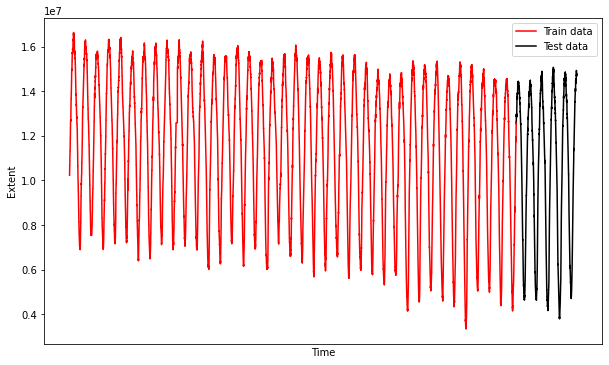

In [227]:
# Plotting the train and test set

plt.figure(figsize=(10,6))
plt.xlabel('Time')
plt.ylabel('Extent')
plt.xticks([])
plt.plot(train, 'red', label='Train data')
plt.plot(test, 'black', label='Test data')
plt.legend();

In [228]:
#dataframe for the test-split
df_test = df_model.iloc[-1892:]
df_test.head()

,date,extent
13947,2017-01-01,12643000.0
13948,2017-01-02,12644000.0
13949,2017-01-03,12713000.0
13950,2017-01-04,12954000.0
13951,2017-01-05,12956000.0


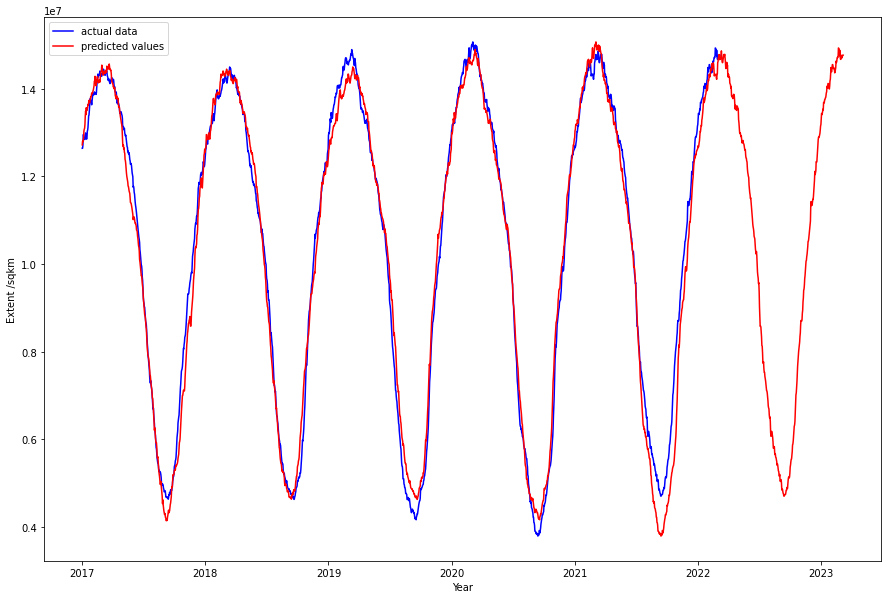

In [229]:
#plotting actual values and predicted values together
plt.figure(figsize=(15,10))
plt.xlabel('Year')
plt.ylabel('Extent /sqkm')
plt.plot(df_test['date'], df_test['extent'], 'b', label='actual data')
plt.plot(df_pred['date'], df_pred['y_pred'], 'r', label='predicted values')
plt.legend();

#### Evaluate the model

In [155]:
#merging the dataframes for the test-period together
df_error = pd.merge(df_test, df_pred, how='inner', on=['date'])
df_error['abs_error'] = abs(df_error['extent'] - df_error['y_pred'])
df_error['APE'] = df_error['abs_error']/df_error['extent']
df_error

,date,extent,y_pred,abs_error,APE
0,2017-01-01,12643000.0,12721000.0,78000.0,0.006169
1,2017-01-02,12644000.0,12806000.0,162000.0,0.012812
2,2017-01-03,12713000.0,12790000.0,77000.0,0.006057
3,2017-01-04,12954000.0,12829000.0,125000.0,0.009650
4,2017-01-05,12956000.0,12874000.0,82000.0,0.006329
...,...,...,...,...,...
1886,2022-03-03,14703000.0,14734000.0,31000.0,0.002108
1887,2022-03-04,14748000.0,14783000.0,35000.0,0.002373
1888,2022-03-05,14762000.0,14748000.0,14000.0,0.000948
1889,2022-03-06,14756000.0,14666000.0,90000.0,0.006099


In [156]:
print('Mean absolute error: ' + str(round(np.mean(df_error['abs_error']),3)))
# the same as: print(round(mean_absolute_error(df_error['extent'], df_error['y_pred']),3))
print('Mean absolute percentage error: ' + str(round(np.mean(df_error['APE']),3)))
print('RMSE: ' + str(round(mean_squared_error(df_error['extent'], df_error['y_pred'], squared=False),3)))

Mean absolute error: 339952.935
Mean absolute percentage error: 0.042
RMSE: 449322.539
